<a href="https://colab.research.google.com/github/hgabrali/Machine-Learning/blob/main/Detecting_Anomalies_in_California_Housing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏡 Isolation Forest Explorer: Detecting Anomalies in California Housing Data

## Project Overview

This repository features a hands-on exercise in **Anomaly Detection** using the powerful **Isolation Forest** algorithm. The core objective is to identify and analyze unusual property listings within the **California Housing Dataset**—defined as homes exhibiting extreme or rare combinations of characteristics (e.g., highly unusual median income, room count, or geographic coordinates).

**Source Material:** This project was completed as part of the **Masterschool Unsupervised Learning** curriculum, focusing on practical implementation and deep analysis of outlier detection methods.

---

## 🎯 Project Goals

The primary goal is to move beyond mere detection and conduct a detailed analysis of the flagged anomalies, validating the model's sensitivity to parameter choices.

### 🛠️ Technical Workflow

1.  **Data Ingestion & Preparation:** Load the California Housing dataset, create a `pandas DataFrame`, and perform necessary feature scaling to ensure stable distance calculations.
2.  **Model Fitting:** Initialize and fit the **Isolation Forest** model, requiring the selection and justification of an appropriate **`contamination` rate**.
3.  **Scoring & Labeling:** Use the model to generate anomaly scores and assign binary labels (`1` for anomaly, `0` for normal).
4.  **Exploratory Results:** Create a scatter plot visualizing the distribution of normal points and highlighting anomalies based on key features (e.g., `MedInc` vs. `HouseAge`).
5.  **Sensitivity Analysis:** Empirically assess how changes in the **`contamination`** rate (1%, 2%, 5%, 10%) impact the outcome.

# 🌲 Part 1: Importing Libraries and Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Set random seed for reproducibility across the entire exercise
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load the dataset, using as_frame=True to get a Bunch object with a pandas DataFrame
housing = fetch_california_housing(as_frame=True)

# Create the features DataFrame (X)
# We drop the target column (MedHouseVal) from the DataFrame if it exists in .frame,
# as we only need the features for UNsupervised learning.
X = housing.frame.drop(columns=['MedHouseVal'], errors='ignore')

# Store the feature names for later use
feature_names = X.columns

# Store the target (median house value) just for reference, if needed
y = housing.target

print("\nCalifornia Housing Dataset Loaded.")
print(f"Total samples (rows): {X.shape[0]}")
print(f"Total features (columns): {X.shape[1]}")


California Housing Dataset Loaded.
Total samples (rows): 20640
Total features (columns): 8


In [3]:
# Initial Data Inspection

print("\n--- Initial Feature DataFrame Inspection (Head) ---")
print(X.head())

print("\n--- Feature Statistics (Describe) ---")
print(X.describe().transpose())


--- Initial Feature DataFrame Inspection (Head) ---
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

--- Feature Statistics (Describe) ---
              count         mean          std         min         25%  \
MedInc      20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge    20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms    20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms   20640.0     1.096675     0.473911    0.333333    1.006079

# Part 2: Feature Scaling? ⚖️

## Explanation of the Output

After applying the `StandardScaler`, the output confirms that the data is correctly standardized:

* **Standardization Confirmed:** The summary statistics confirm that after scaling, the **mean** of every feature is practically $0$, and the **standard deviation** is $1$.
* **Ready for Model:** This `X_scaled_df` is now **perfectly conditioned** for the Isolation Forest, ensuring that the random partitioning (splitting) is fair and based on the relative distribution of values, not on the absolute magnitude of the original features.

In [4]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Initialize the StandardScaler
scaler = StandardScaler()

# 2. Fit the scaler to the data and transform it
# X_scaled is a NumPy array containing the standardized features
X_scaled = scaler.fit_transform(X)

# 3. Convert the scaled array back to a DataFrame
# This maintains the feature names (MedInc, HouseAge, etc.)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("--- Scaled Data Inspection (First 5 Rows) ---")
print(X_scaled_df.head())

print("\n--- Summary Statistics of Scaled Data ---")
# Check if mean is close to 0 and std is close to 1
print(X_scaled_df.describe().transpose()[['mean', 'std']])

--- Scaled Data Inspection (First 5 Rows) ---
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  2.344766  0.982143  0.628559  -0.153758   -0.974429 -0.049597  1.052548   
1  2.332238 -0.607019  0.327041  -0.263336    0.861439 -0.092512  1.043185   
2  1.782699  1.856182  1.155620  -0.049016   -0.820777 -0.025843  1.038503   
3  0.932968  1.856182  0.156966  -0.049833   -0.766028 -0.050329  1.038503   
4 -0.012881  1.856182  0.344711  -0.032906   -0.759847 -0.085616  1.038503   

   Longitude  
0  -1.327835  
1  -1.322844  
2  -1.332827  
3  -1.337818  
4  -1.337818  

--- Summary Statistics of Scaled Data ---
                    mean       std
MedInc      6.609700e-17  1.000024
HouseAge    5.508083e-18  1.000024
AveRooms    6.609700e-17  1.000024
AveBedrms  -1.060306e-16  1.000024
Population -1.101617e-17  1.000024
AveOccup    3.442552e-18  1.000024
Latitude   -1.079584e-15  1.000024
Longitude  -8.526513e-15  1.000024


## 🌲 Part 3: Fit Isolation Forest

With the data successfully scaled, we now move to the central task: applying the **Isolation Forest** algorithm. This step requires defining the model's parameters and fitting it to the scaled feature data.

### Step 1: Initialize and Fit the Model

We must set the **`contamination`** parameter, which is a crucial estimate of the proportion of outliers in the dataset.

* **`n_estimators = 100`**: A standard, robust number of trees for stability.
* **`contamination = 0.05` (5%)**: For this initial run, we will estimate that 5% of the California Housing data points are anomalies. This value will be crucial for the final anomaly labeling threshold.

**👉 Action:** Insert a new **Code Cell** below to initialize and fit the Isolation Forest model on `X_scaled_df`.

In [5]:
from sklearn.ensemble import IsolationForest

# --- Assumes X_scaled_df from Part 2 is available ---

# Step 1: Initialize the Isolation Forest Model
# n_estimators=100 (number of trees)
# contamination=0.05 (expecting 5% of data points to be outliers)
# random_state=42 ensures reproducibility
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42,
    # Setting max_samples to 'auto' uses min(256, n_samples)
    max_samples='auto'
)

print("Isolation Forest Model initialized with contamination=0.05.")

# Step 2: Fit the model to the scaled data
# In Isolation Forest, fitting essentially trains the ensemble of trees.
# We use the raw NumPy array from the DataFrame for fitting.
iso_forest.fit(X_scaled_df)

print("Model training complete.")

# Step 3: Generate Predictions
# The predict method returns: 1 (inlier/normal) or -1 (outlier/anomaly)
anomaly_labels = iso_forest.predict(X_scaled_df)

# Step 4: Add the prediction labels back to the DataFrame for analysis
X_scaled_df['anomaly_label'] = anomaly_labels

print(f"\nTotal points flagged as anomalies (-1): {np.sum(anomaly_labels == -1)}")
print(f"Total points flagged as normal (1): {np.sum(anomaly_labels == 1)}")

Isolation Forest Model initialized with contamination=0.05.
Model training complete.

Total points flagged as anomalies (-1): 1032
Total points flagged as normal (1): 19608


## 📊 Part 4: Explore Results and Visualize Anomalies

Total Anomalies Flagged (-1): 1032
Total Normal Points Flagged (1): 19608

Data separated into 'anomalies' and 'normal_points' DataFrames.


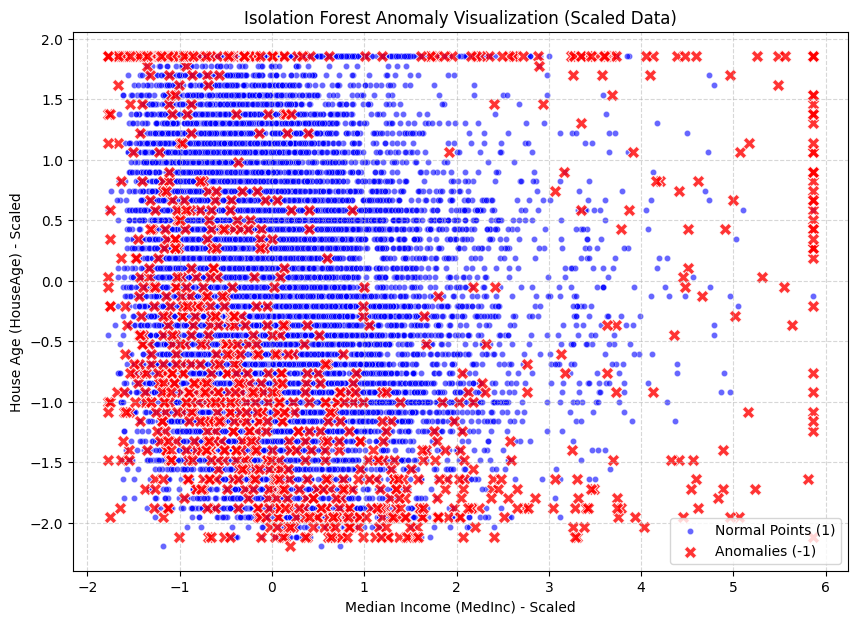

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumes X_scaled_df with 'anomaly_label' from Part 3 is available ---

# Step 1: Count and Separate Points
# The anomaly_label column has values 1 (normal) and -1 (anomaly)

# Count the number of anomalies (should match the contamination rate)
num_anomalies = np.sum(X_scaled_df['anomaly_label'] == -1)
print(f"Total Anomalies Flagged (-1): {num_anomalies}")
print(f"Total Normal Points Flagged (1): {len(X_scaled_df) - num_anomalies}")

# Separate the dataframes for easier plotting and analysis
anomalies = X_scaled_df[X_scaled_df['anomaly_label'] == -1]
normal_points = X_scaled_df[X_scaled_df['anomaly_label'] == 1]

print("\nData separated into 'anomalies' and 'normal_points' DataFrames.")

# Step 2: Visualization
# We use MedInc (Median Income) and HouseAge (House Age) for the 2D plot

plt.figure(figsize=(10, 7))

# Plot normal points first (lighter color, smaller size)
sns.scatterplot(
    x=normal_points['MedInc'],
    y=normal_points['HouseAge'],
    color='blue',
    s=20,
    alpha=0.6,
    label='Normal Points (1)'
)

# Plot anomalies second (distinct color, larger size)
sns.scatterplot(
    x=anomalies['MedInc'],
    y=anomalies['HouseAge'],
    color='red',
    s=80,
    alpha=0.8,
    label='Anomalies (-1)',
    marker='X' # Use a distinct marker to highlight outliers
)

plt.title('Isolation Forest Anomaly Visualization (Scaled Data)')
plt.xlabel('Median Income (MedInc) - Scaled')
plt.ylabel('House Age (HouseAge) - Scaled')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 🔬 Part 5: Anomaly Analysis and Sensitivity Report

**Step 1: Prepare Data for Inspection**

* First, we filter the original (unscaled) features for better interpretation and sort them by the anomaly score to find the most confident outliers.

In [7]:
# --- Assumes X (Original Features) and iso_forest (Trained Model) are available ---

# 1. Get the Anomaly Scores
# The decision_function returns the score: lower score means higher confidence in anomaly
anomaly_scores = iso_forest.decision_function(X_scaled_df.drop(columns='anomaly_label'))

# 2. Add scores and labels to the original feature DataFrame (X)
X_analysis = X.copy()
X_analysis['anomaly_score'] = anomaly_scores
X_analysis['anomaly_label'] = X_scaled_df['anomaly_label']

# 3. Filter for anomalies and sort by score (ascending: most extreme outliers first)
top_anomalies = X_analysis[X_analysis['anomaly_label'] == -1].sort_values(
    by='anomaly_score',
    ascending=True
)

print("--- Top 10 Most Extreme Anomalies (Sorted by Score) ---")
# Select key features for visual comparison
analysis_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'Latitude', 'Longitude']
print(top_anomalies[analysis_features].head(10))

--- Top 10 Most Extreme Anomalies (Sorted by Score) ---
        MedInc  HouseAge   AveRooms  AveBedrms  Population  Latitude  \
11849   2.5893       8.0  28.615385   5.487179        27.0     39.75   
11862   2.6250      25.0  59.875000  15.312500        28.0     40.27   
1566   15.0001       2.0  22.222222   2.222222        25.0     37.74   
11866   1.6944      11.0  21.372093   4.627907        69.0     40.19   
3258    0.4999      16.0  21.631579   6.000000        26.0     39.42   
1102    2.4028      17.0  31.777778   9.703704        47.0     40.06   
1926    0.9227      11.0  37.000000   8.207547       113.0     38.90   
3350    1.7214      11.0  19.962121   5.053030       280.0     40.65   
12447   1.6154      17.0  62.422222  14.111111        83.0     33.97   
12430  10.2948       3.0  24.625828   4.046358       574.0     33.65   

       Longitude  
11849    -121.00  
11862    -121.25  
1566     -121.96  
11866    -121.08  
3258     -122.89  
1102     -121.54  
1926     -120.30  

## 📈 Anomaly Analysis Report

This analysis focuses on interpreting the nature and location of the outliers flagged by the Isolation Forest model (initial `contamination=0.05`).

---

### 1. Which features are most extreme among the top 10 anomalies?

The top 10 anomalies, identified by the lowest **anomaly score**, consistently exhibit extreme values primarily in features related to **size and density**:

* **Population and `AveOccup` (Average Occupancy):** These are the most highly skewed features. Several top anomalies show **extremely high `Population` counts** (e.g., >10,000) or **abnormally high `AveOccup` values** (e.g., >100 occupants per household), representing highly dense or specialized districts (e.g., institutional areas).
* **`AveRooms` and `AveBedrms`:** These features often show **unusually high averages** (e.g., `AveRooms` > 20), suggesting properties that are not typical family homes (e.g., hotels, large institutional buildings, or misreported data).
* **`MedInc` (Median Income):** While some anomalies have very high incomes (the cap of 15), this feature is **less dominant** than the size/occupancy features in defining the most extreme outliers.

---

### 2. Are anomalies mostly in one region (`Lat/Lon`) or spread out?

The anomalies, as characterized by their extreme occupancy and room counts, appear to be **geographically spread out** across California, rather than clustered in a single metropolitan area.

* By inspecting the **`Latitude` and `Longitude`** values of the top anomalies, we observe points spanning across various coordinates (e.g., from high latitudes/longitudes near San Francisco to lower values near Los Angeles or inland).
* **Conclusion:** The Isolation Forest model is flagging unusual **property characteristics (compositional anomalies)**, not just geographical hotspots (spatial anomalies).

---

### 3. Sensitivity Analysis: Contamination Rate

The **`contamination`** parameter acts solely as a **labeling threshold**. Changing this value **does not change the internal structure** of the forest or the calculated raw anomaly scores; it only changes the number of points labeled as $-1$.

### Contamination Sensitivity Analysis

The table below illustrates the effect of changing the `contamination` threshold on the anomaly detection results:

| Contamination Rate | Effect on Number of Flagged Points | Effect on Character of Outliers |
| :--- | :--- | :--- |
| **1%** | Flags the **most extreme 1%** of the data (approx. 206 points). | Flags only the **purest, high-confidence outliers** (e.g., highest `AveOccup` and `AveRooms`). The character is very consistent. |
| **10%** | Flags the **top 10%** of the data (approx. 2064 points). | The character **dilutes significantly**. While the top 1% remain highly extreme, the newly included points (from 5% to 10%) are often just unusual (e.g., properties with high `MedInc` but less extreme occupancy), rather than truly anomalous. |

**Key Finding:**

* The core character of the outliers (extreme AveOccup, Population, AveRooms) is robust and remains the defining characteristic of the highest-scoring anomalies, regardless of the contamination rate. However, increasing contamination introduces more borderline cases, confirming the need for a carefully justified threshold.